In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from packet_utils import create_802154_phy_packet, map_nibbles_to_chips, split_iq_chips
from modulation import oqpsk_modulate, half_sine_fir_taps
from transmitter import Transmitter802154
from receiver import Receiver802154

# IEEE 802.15.4

## Payload -> packet (bytes, with CRC if wanted)

In [2]:
# Example values:
payload = np.array([0xAB, 0xCD], dtype=np.uint8)
append_crc = True

packet = create_802154_phy_packet(payload, append_crc=append_crc)
print("Packet bytes:")
print([hex(byte) for byte in packet])

Packet bytes:
['0x0', '0x0', '0x0', '0x0', '0xa7', '0x4', '0xab', '0xcd', '0xbe', '0x56']


## Packet bytes -> chips

In [3]:
# Chip mapping for IEEE 802.15.4 O-QPSK DSSS encoding
chip_mapping: np.ndarray = np.array(
    [
        0xD9C3522E,  # 0
        0xED9C3522,  # 1
        0x2ED9C352,  # 2
        0x22ED9C35,  # 3
        0x522ED9C3,  # 4
        0x3522ED9C,  # 5
        0xC3522ED9,  # 6
        0x9C3522ED,  # 7
        0x8C96077B,  # 8
        0xB8C96077,  # 9
        0x7B8C9607,  # A
        0x77B8C960,  # B
        0x077B8C96,  # C
        0x6077B8C9,  # D
        0x96077B8C,  # E
        0xC96077B8,  # F
    ],
    dtype=np.uint32,
)

chips = map_nibbles_to_chips(packet, chip_mapping, return_string=False)
print([hex(byte) for byte in chips])


# def binary_string_to_bit_array(binary_string: str) -> np.ndarray:
#     """Receives string of bits like '10101111_01110010' and converts it into a np.array"""
#     return np.array([int(bit) for bit in binary_string if bit in "01"], dtype=np.uint8)


# print(binary_string_to_bit_array(chips))

['0xd9c3522e', '0xd9c3522e', '0xd9c3522e', '0xd9c3522e', '0xd9c3522e', '0xd9c3522e', '0xd9c3522e', '0xd9c3522e', '0x9c3522ed', '0x7b8c9607', '0x522ed9c3', '0xd9c3522e', '0x77b8c960', '0x7b8c9607', '0x6077b8c9', '0x77b8c96', '0x96077b8c', '0x77b8c960', '0xc3522ed9', '0x3522ed9c']


## Chips -> (I_chips, Q_chips)

In [4]:
# Example usage:
I_chips, Q_chips = split_iq_chips(chips[:1])

print("I_chips:", I_chips)
print("Q_chips:", Q_chips)

I_chips: [1 0 1 0 1 0 0 1 0 0 0 1 0 1 1 1]
Q_chips: [1 1 0 1 1 0 0 1 1 1 0 0 0 0 1 0]


## Half-sine shaping, from split chips to O-QPSK modulation

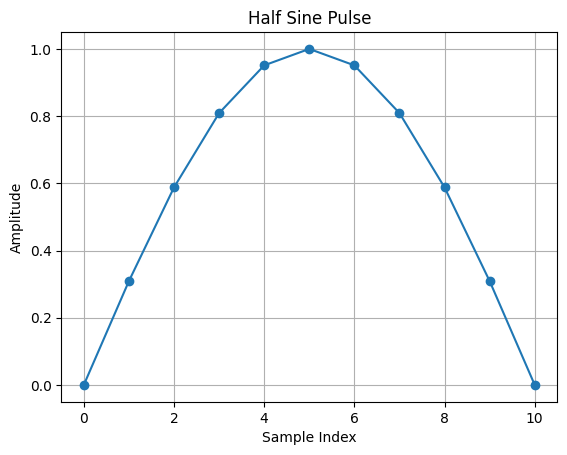

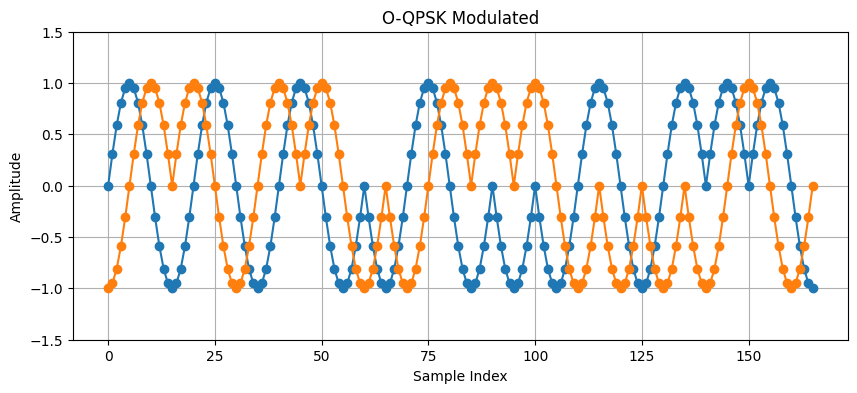

In [5]:
sps = 10

# Generate the half-sine pulse
half_sine_pulse = half_sine_fir_taps(sps)
oqpsk_signal = oqpsk_modulate(I_chips, Q_chips, half_sine_pulse, sps)

plt.figure()
plt.plot(half_sine_pulse, marker="o")
plt.title("Half Sine Pulse")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

# Plot the modulated data
plt.figure(figsize=(10, 4))
plt.plot(np.real(oqpsk_signal), marker="o", linestyle="-")
plt.plot(np.imag(oqpsk_signal), marker="o", linestyle="-")
plt.title("O-QPSK Modulated")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.ylim((-1.5, 1.5))
plt.grid(True)
plt.show()

## Encapsulate IEEE 802.15.4 modulation (from payload to IQ)

[{'payload': array([ 0,  0,  0,  0,  2,  4,  6,  8, 10, 12], dtype=uint8), 'length': 10, 'crc_check': True, 'position_in_array': 484}]


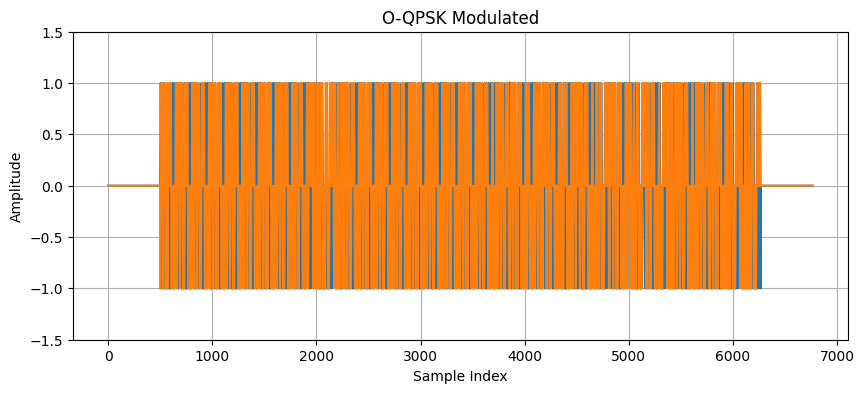

In [6]:
fs = 10e6  # Hz

class_payload = np.array([0, 0, 0, 0, 2, 4, 6, 8, 10, 12], dtype=np.uint8)

transmitter = Transmitter802154(fs=fs)
class_bits = transmitter.process_phy_payload(class_payload)
class_modulated = transmitter.modulate(class_bits, zero_padding=500)

receiver = Receiver802154(fs=fs)
received_bit_samples = receiver.demodulate(class_modulated)
received_packet = receiver.process_phy_packet(received_bit_samples)
print(received_packet)

# Plot the modulated data
plt.figure(figsize=(10, 4))
plt.plot(np.real(class_modulated), linestyle="-")
plt.plot(np.imag(class_modulated), linestyle="-")
plt.title("O-QPSK Modulated")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.ylim((-1.5, 1.5))
plt.grid(True)
plt.show()